In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
Root = "/content/drive/MyDrive/Biển báo giao thông"
os.chdir(Root)

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [6]:
data_dir = "/content/drive/MyDrive/Biển báo giao thông"
train_path = 'Train'
test_path = 'Test'

# Thiết lâp kích thước ảnh (30x30x3)
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [7]:
# Số lượng doanh mục trong (train_path)
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

44

In [8]:
# Tổng quan về các nhãn
classes = { 0:'Giới hạn tốc độ (20km/h)',
            1:'Giới hạn tốc độ (30km/h)',
            2:'Giới hạn tốc độ (50km/h)',
            3:'Giới hạn tốc độ (60km/h)',
            4:'Giới hạn tốc độ (70km/h)',
            5:'Giới hạn tốc độ (80km/h)',
            6:'Hết giới hạn tốc độ (80km/h)',
            7:'Giới hạn tốc độ (100km/h)',
            8:'Giới hạn tốc độ (120km/h)',
            9:'Không ',
            10:'Cấm vượt xe trên 3,5 tấn',
            11:'Quyền ưu tiên tại giao lộ',
            12:'Đường ưu tiên',
            13:'Biển nhường đường',
            14:'Stop',
            15:'Cấm đỗ xe',
            16:'Cấm xe > 3,5 ',
            17:'Đường một chiều',
            18:'Nguy Hiểm',
            19:'Nguy hiểm rẽ trái',
            20:'Nguy Hiểm rẽ phải',
            21:'Đường ngoằn ngoèo ',
            22:'Đường gập ghềnh',
            23:'Đường trơn',
            24:'Đường hẹp bên phải',
            25:'Đường đang thi ',
            26:'Đèn giao ',
            27:'Người đi bộ',
            28:'Trẻ em qua đường',
            29:'Xe đạp qua đường',
            30:'Coi trừng băng tuyết',
            31:'Động vật băng ',
            32:'Hết mọi lệnh cấm',
            33:'Rẽ phải về phía trước',
            34:'Rẽ trái về phía trước',
            35:'Chỉ được đi thẳng',
            36:'Đi thằng hoặc rẽ phải',
            37:'Đi thằng hoặc rẽ trái',
            38:'Đi bên phải',
            39:'Đi bên trái',
            40:'Vòng xuyến',
            41:'Kết thúc không đi qua',
            42:'tonsXe không vợt quá 3,5 tấn' }

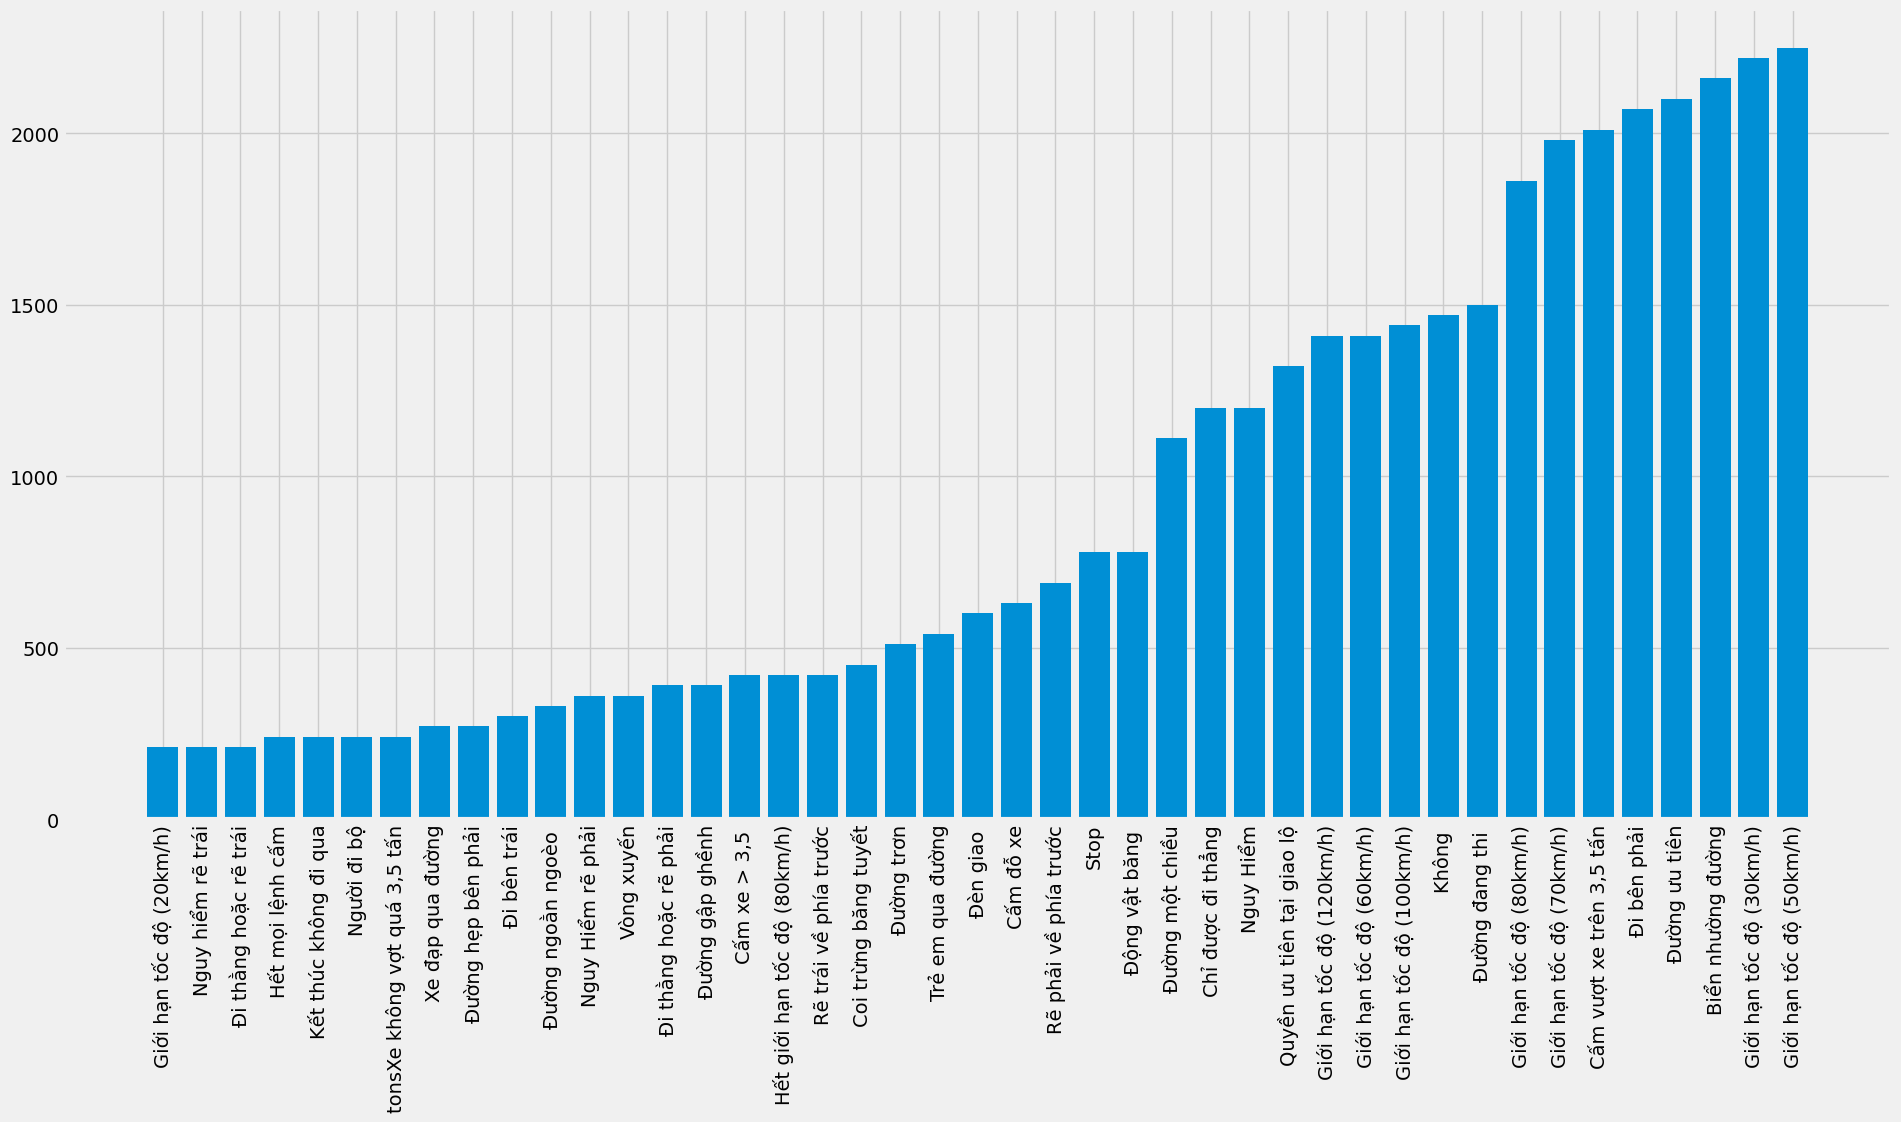

In [9]:
# Lấy danh sách thư mục trong đường dẫn 'Train_path'
folders = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
# Khởi tạo chỗ lưu trữ
train_number = []
class_num = []
# Duyệt qua từng thư mục và đếm số lượng
for folder in folders:
    folder_path = os.path.join(train_path, folder)
    train_files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sắp xếp tập dữ liệu dựa trên số lượng hình ảnh trong mỗi lớp
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Vẽ biểu đồ số lượng hình ảnh trong mỗi lớp
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

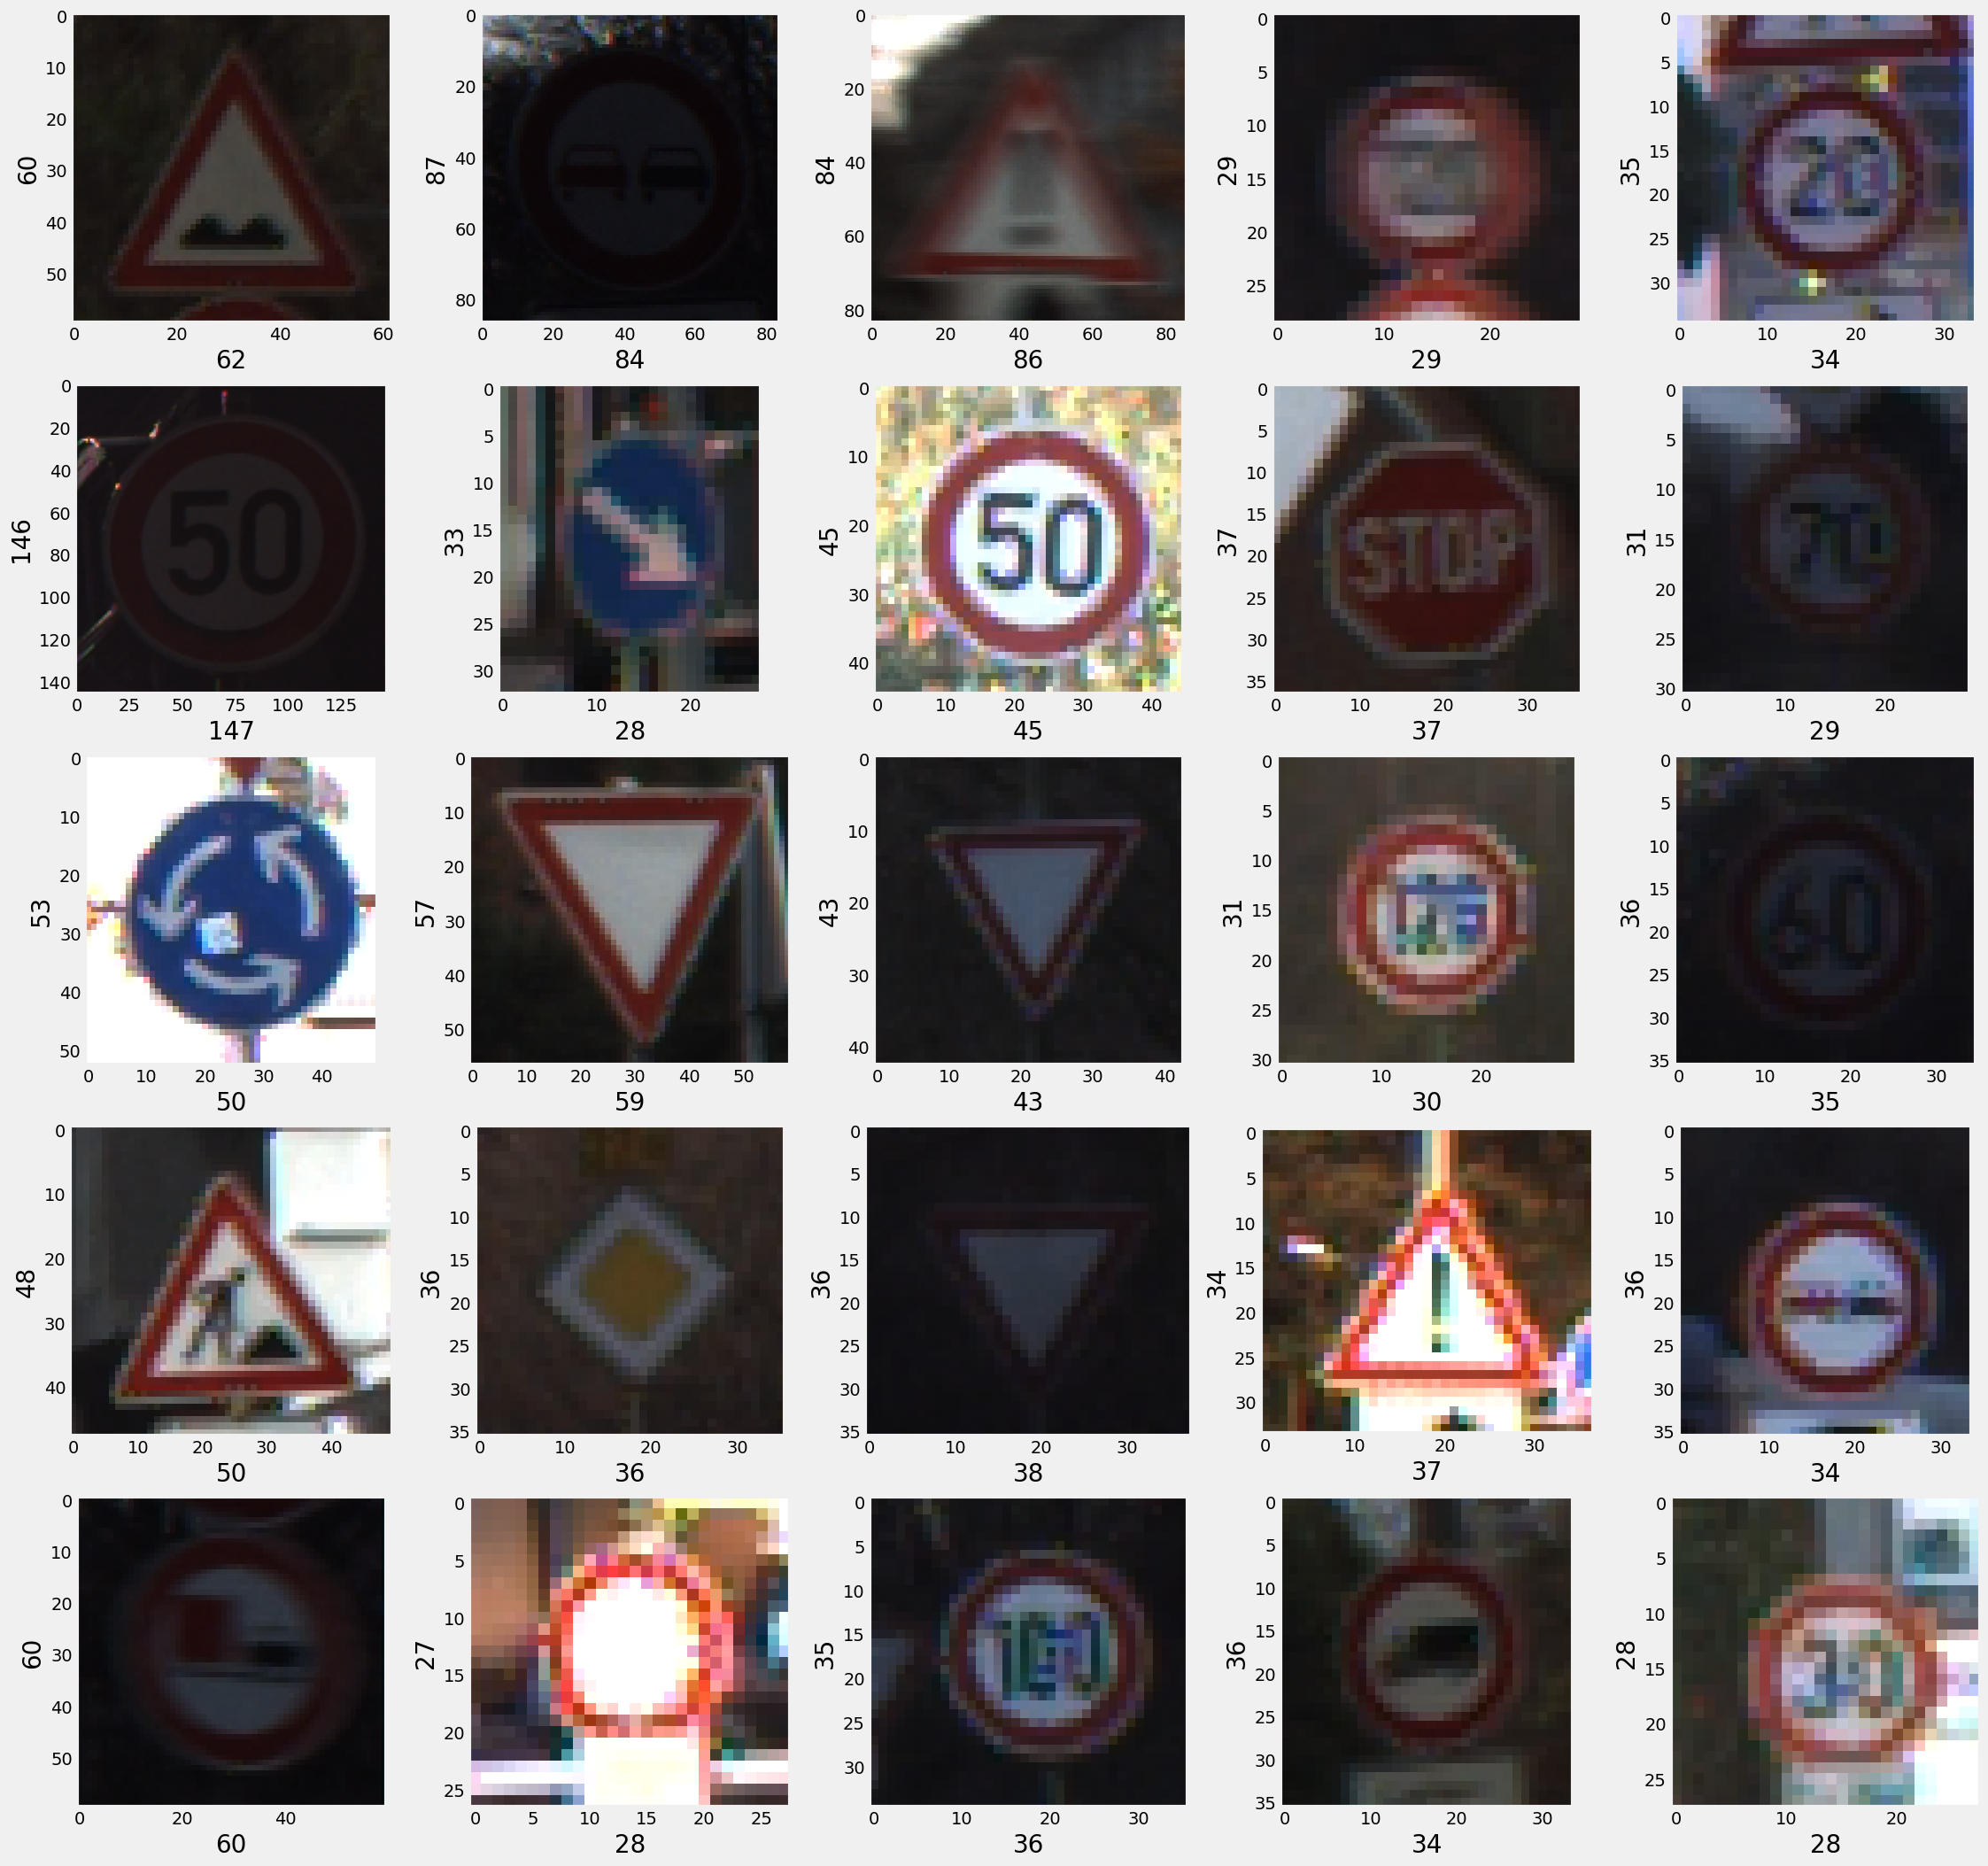

In [10]:
# Hiển thị 25 hình ảnh ngẫu nhiên từ dữ liệu test_data
import random
from matplotlib.image import imread
# Đọc file test_
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values
# Thiết lập kích thước biểu
plt.figure(figsize=(25,25))
# Chọn ngẫu nhiên 25 ảnh từ tập dữ
for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)  # Tắt lưới
    plt.xlabel(rand_img.shape[1], fontsize = 20)  # Chiều rộng của ảnh
    plt.ylabel(rand_img.shape[0], fontsize = 20)  # Chiều cao của ảnh

In [11]:
# Khởi tạo các danh sách để lưu trữ dữ
image_data = []  # Để lưu trữ hình ảnh đã thay đổi kích thước
image_labels = []  # Để lưu trữ nhãn tương ứng
# Duyệt qua các danh mục trong tập huấn luyện
for i in range(NUM_CATEGORIES):
    path = os.path.join(data_dir, 'Train', str(i))
    if os.path.exists(path):  # Kiểm tra xem thư mục tồn tại hay không
        images = os.listdir(path)
        # Xử lý từng hình ảnh trong mỗi thư
        for img in images:
            try:
                # Đọc, thay đổi kích thước và chuyển đổi hình ảnh thành mảng
                image = cv2.imread(os.path.join(path, img))
                image_fromarray = Image.fromarray(image, 'RGB')
                resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
                image_data.append(np.array(resize_image))

                # Thêm nhãn cho hình ảnh hiện tại
                image_labels.append(i)
            except:
                print("Lỗi trong " + img)

# Chuyển đổi danh sách thành mảng NumPy
image_data = np.array(image_data)
image_labels = np.array(image_labels)

# In hình dạng của các mảng kết quả
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [13]:
np.unique(image_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
        1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
         390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
         689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240]))

In [17]:
# Xáo trộn dữ liệu, giúp cân bằng khả năng học
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [18]:
# Chia tập dữ liệu huấn luyện
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [19]:
# Chuyển đối nhãn dữ liệu dạng số nguyên thành One-hot-encoded
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 44)
(11763, 44)


In [20]:
# Xây dựng mô hình mạng nơ-ron tích chập (CNN) được xây dựng bằng framework Keras
NUM_CLASSES = 44  # Thay thế 44 bằng số lượng lớp thực tế trong dữ liệu nhãn của bạn

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [21]:
lr = 0.001
epochs = 30

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
# Tạo ra các biến thể của các hình ảnh trong quá trình huấn luyện
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [24]:
# Huấn luyện mô hình
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 105s 120ms/step - loss: 1.0979 - accuracy: 0.7040 - val_loss: 0.0914 - val_accuracy: 0.9724
Epoch 2/30
858/858 [==============================] - 101s 117ms/step - loss: 0.1898 - accuracy: 0.9417 - val_loss: 0.0950 - val_accuracy: 0.9694
Epoch 3/30
858/858 [==============================] - 102s 119ms/step - loss: 0.1054 - accuracy: 0.9668 - val_loss: 0.0208 - val_accuracy: 0.9950
Epoch 4/30
858/858 [==============================] - 100s 116ms/step - loss: 0.0942 - accuracy: 0.9714 - val_loss: 0.0225 - val_accuracy: 0.9925
Epoch 5/30
858/858 [==============================] - 98s 114ms/step - loss: 0.0843 - accuracy: 0.9733 - val_loss: 0.0134 - val_accuracy: 0.9957
Epoch 6/30
858/858 [==============================] - 99s 115ms/step - loss: 0.0751 - accuracy: 0.9762 - val_loss: 0.0425 - val_accuracy: 0.9872
Epoch 7/30
858/858 [==============================] - 102s 118ms/step - loss: 0.0633 - accuracy: 0.9802 - val_loss: 0.0191 - v

In [25]:
model.save("model_test.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model.save_weights("/content/drive/MyDrive/Data full")

In [27]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertica

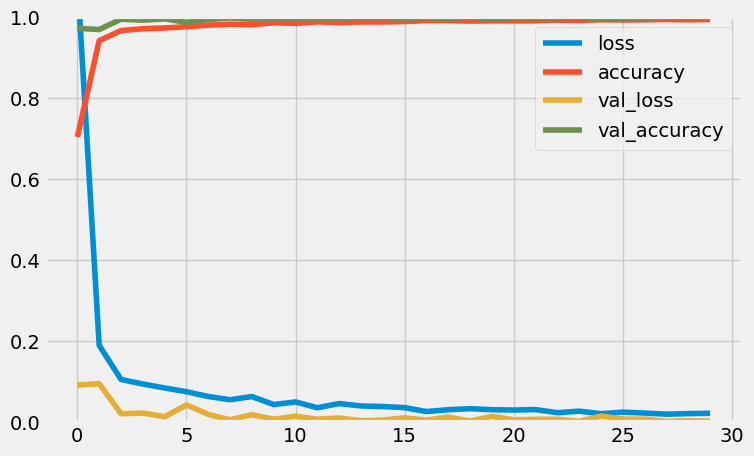

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [29]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print("Độ chính xác trên tập kiểm tra:", test_accuracy)

368/368 [==============================] - 11s 29ms/step - loss: 0.0025 - accuracy: 0.9993
Độ chính xác trên tập kiểm tra: 0.9993199110031128


In [30]:
from tensorflow.keras.models import load_model

# Tải mô hình từ tệp lưu trữ
model = load_model("model_test.h5")

# Load dữ liệu kiểm tra từ tệp CSV
test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
imgs = test["Path"].values

data = []

# Đọc và xử lý dữ liệu hình ảnh kiểm tra
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data) / 255

# Dự đoán với dữ liệu kiểm tra
pred = np.argmax(model.predict(X_test), axis=-1)

# Đánh giá độ chính xác của mô hình trên dữ liệu kiểm tra
from sklearn.metrics import accuracy_score
print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)

395/395 [==============================] - 10s 26ms/step
Test Data accuracy:  98.36104513064133


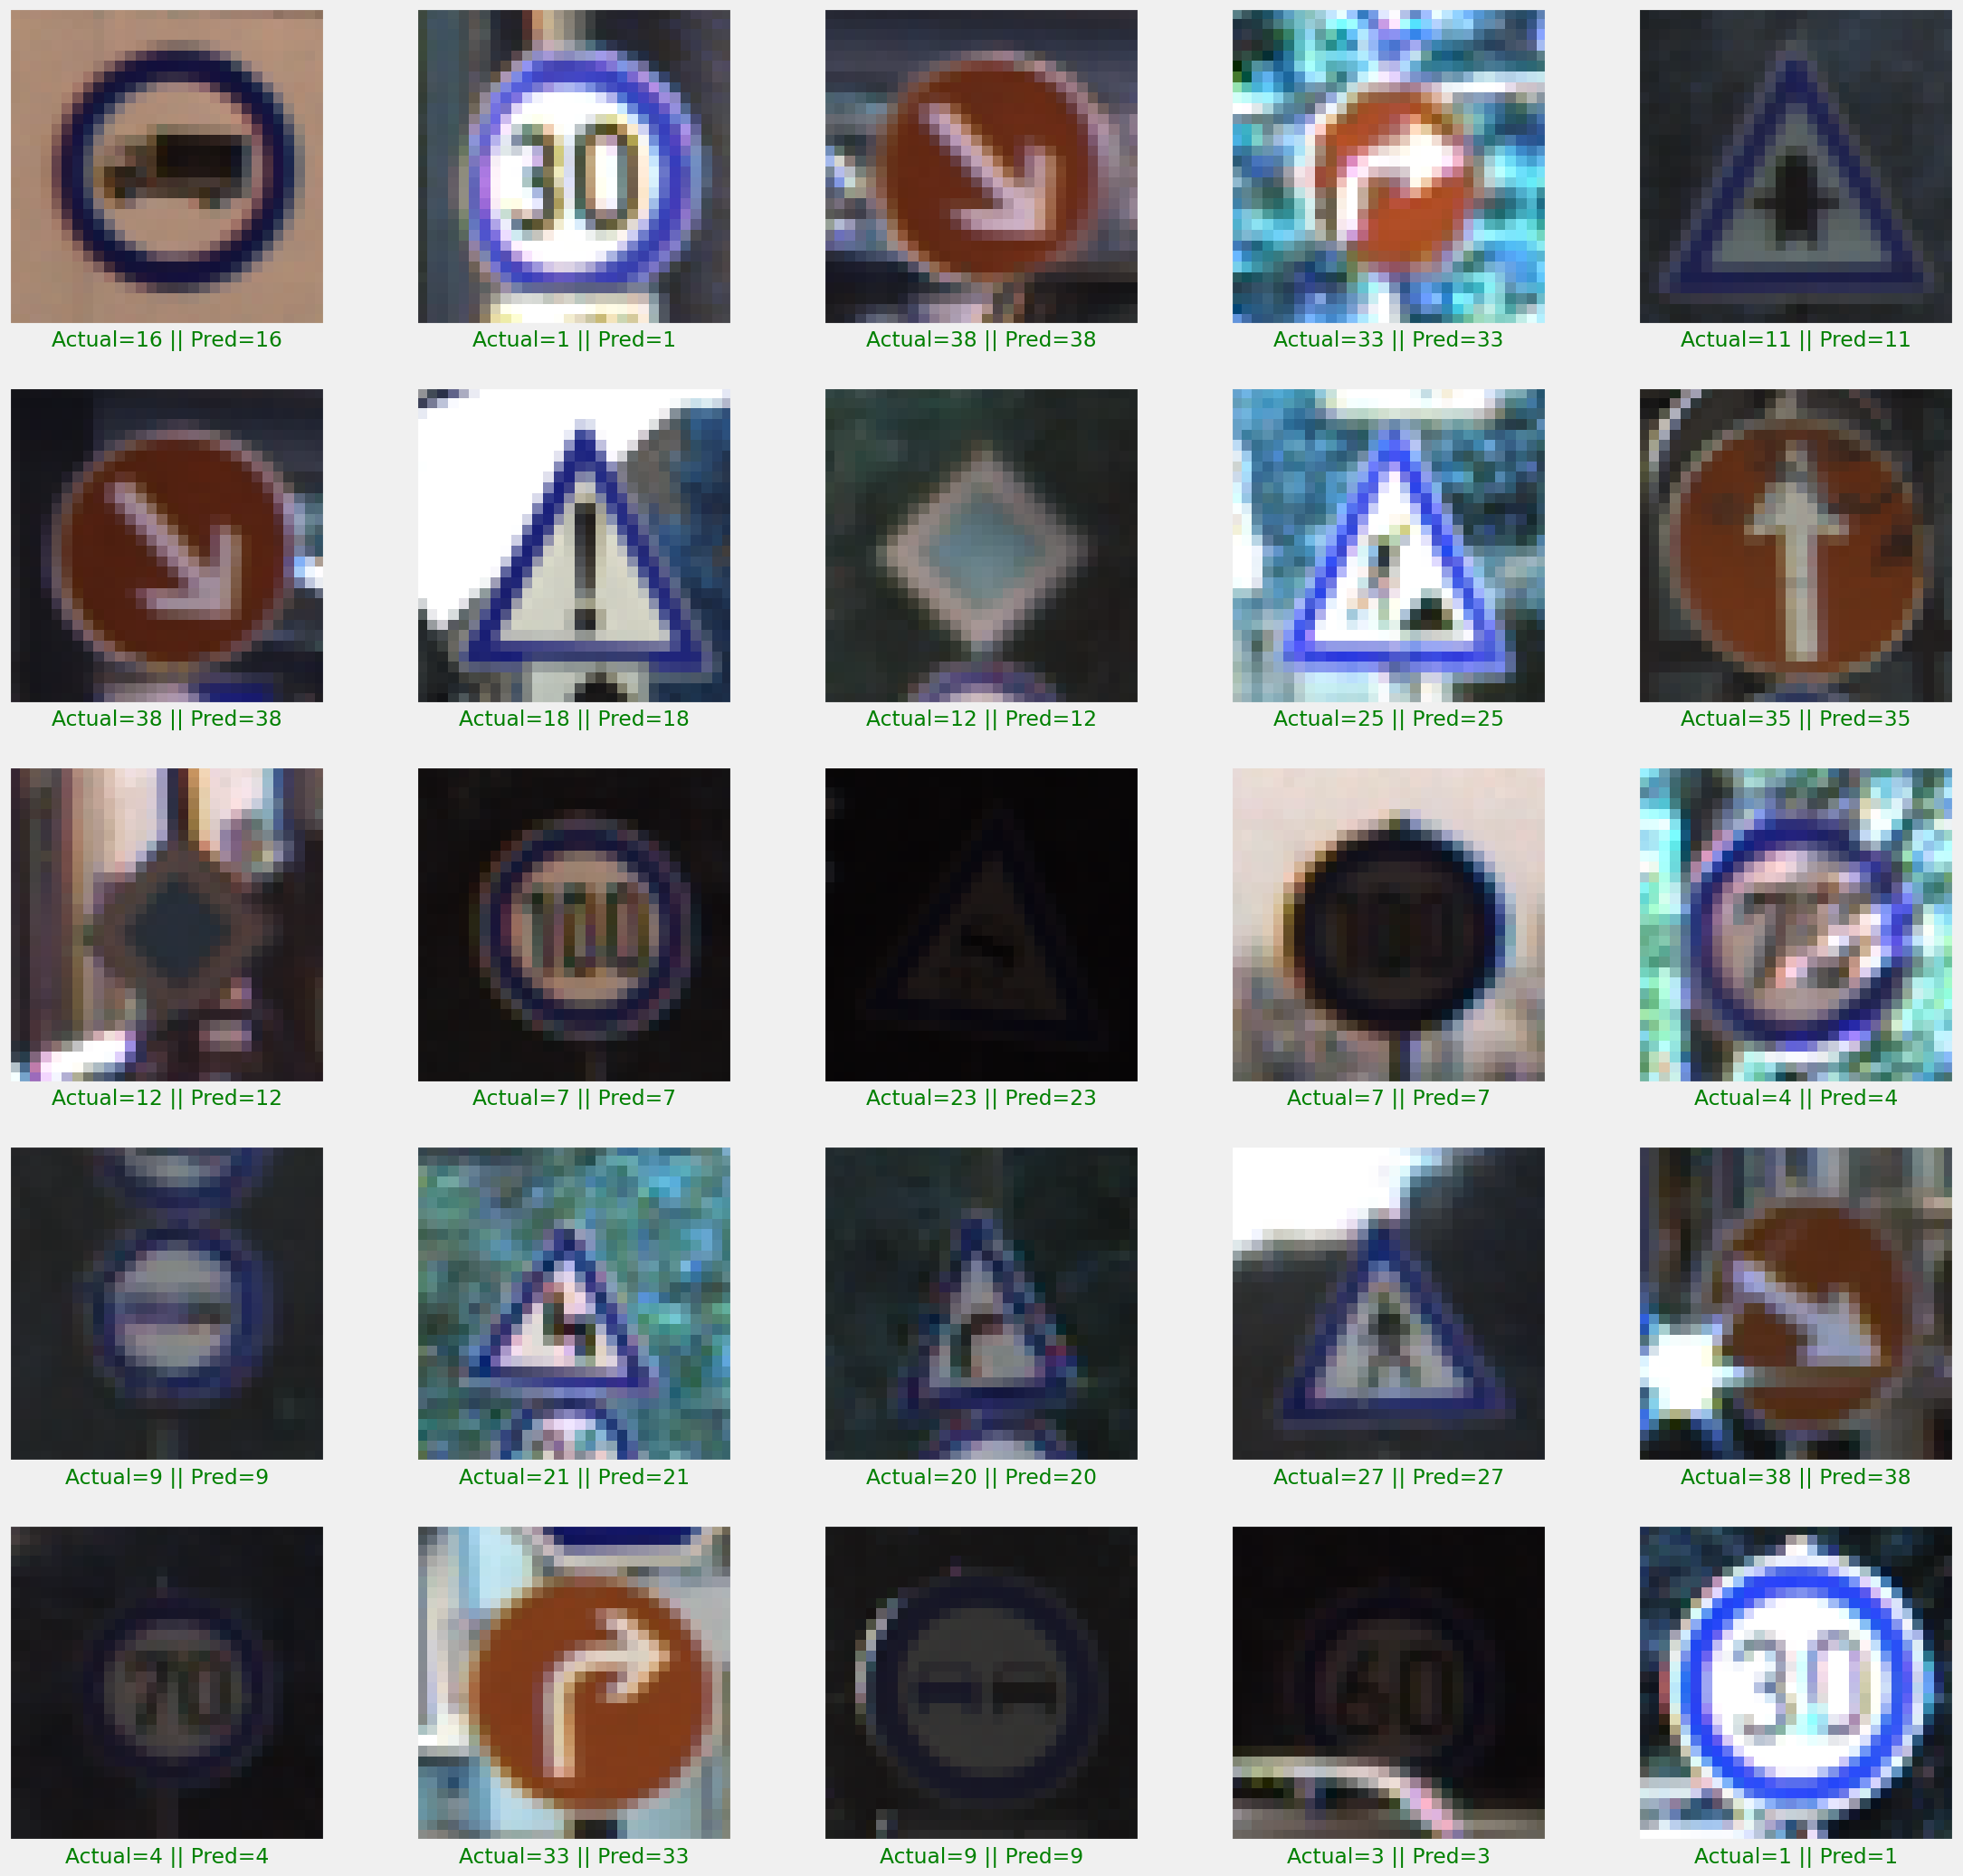

In [33]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [34]:
ls

 download.jpg   Meta.csv       'Nhận dạng biển báo giao thông.ipynb'   Test_1.jpg   Train/
 Meta/          model_test.h5   Test/                                  Test.csv     Train.csv


1/1 [==============================] - 0s 121ms/step


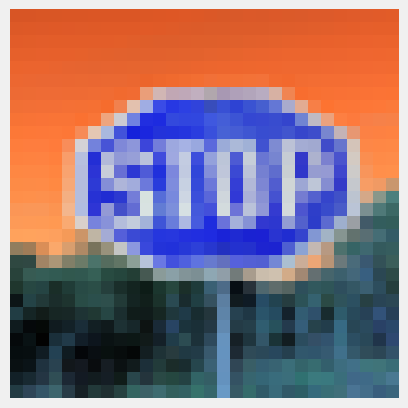

Tên biển báo giao thông: Stop


In [39]:
model_path = "model_test.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Biển báo giao thông/Test_1.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
# Hiển thị hình ảnh
plt.imshow(resize_image)
plt.axis('off')
plt.show()
# In ra tên của biển báo giao thông
sign_name = classes[result]
print("Tên biển báo giao thông:", sign_name)